In [ ]:
#! pip install scikeras
#! pip install matplotlib
#!pip install seaborn

import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.utils import plot_model
import seaborn as sns

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
Train = pd.read_csv("USCensusTraining.csv", na_values=[" ?","?","? "])
Train['income'] = Train['income'].map({'>50K.':1,'<=50K.':0})
Train = Train.drop(columns=['education-num'])  # drop 'education-num' as it's redundant with 'education'
Train = Train[Train['native-country'] != 'Holand-Netherlands']

cat_cols = Train.select_dtypes(exclude=['number']).columns.tolist()

for col in cat_cols:
    dominant_value = Train[col].mode()[0]
    Train[col] = Train[col].fillna(dominant_value)

X_t = Train.drop(columns=["income"])
y_t = Train["income"]

X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

# 3) Column types


numcol = X_train.select_dtypes(include=['number']).columns
catcol = X_train.select_dtypes(exclude=['number']).columns


# 4) Preprocess: impute+scale numeric, impute+onehot categorical
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", preprocessing.MinMaxScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # use sparse=False if needed
])


preprocessor = ColumnTransformer(
    transformers= [
        ("num", numeric_pipe, numcol),
        ("cat", categorical_pipe, catcol)
    ], remainder="drop"
)

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared  = preprocessor.transform(X_test)

X_prepared = preprocessor.transform(Train)
#pd.DataFrame(X_train_prepared).describe()
#pd.DataFrame(X_test_prepared).describe()

In [17]:
def build_model(optimizer="RMSprop", lr=0.001, units=32, act="sigmoid"):
    model = Sequential(name="ANN_Tunable")
    model.add(Input(shape=(X_train_prepared.shape[1],), name="input_features")) 
    model.add(Dense(units, activation=act, kernel_initializer="glorot_uniform", name="hidden"))
    model.add(Dense(1, activation="sigmoid", name="output"))
    
    if isinstance(optimizer, str):
        opt_name = optimizer.lower()
        if opt_name == "rmsprop":
            opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
        elif opt_name in ("sgd", "sgd_m"):
            opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        else:
            opt = tf.keras.optimizers.get(optimizer)
    else:
        opt = optimizer
        
    model.compile(optimizer=opt,loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [ ]:
clf = KerasClassifier(model=build_model, epochs=40, batch_size=32, verbose=2, random_state=42) #the purpose of this line is to wrap the Keras model so it can be used by scikit-learn
param_grid = {
    "model__units": [16, 32, 64],
    "model__optimizer": ["RMSprop", "sgd"],
    "model__lr": [0.01, 0.001],
    "model__act": ["relu","sigmoid"],
    "epochs": [20],
    "batch_size": [32]   
}

Grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=3, scoring="accuracy", verbose=2)


In [26]:
Grid_search.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Epoch 1/20
625/625 - 1s - 2ms/step - accuracy: 0.8054 - loss: 0.4070
Epoch 2/20
625/625 - 1s - 1ms/step - accuracy: 0.8391 - loss: 0.3469
Epoch 3/20
625/625 - 1s - 2ms/step - accuracy: 0.8422 - loss: 0.3398
Epoch 4/20
625/625 - 1s - 1ms/step - accuracy: 0.8445 - loss: 0.3356
Epoch 5/20
625/625 - 1s - 1ms/step - accuracy: 0.8455 - loss: 0.3325
Epoch 6/20
625/625 - 1s - 1ms/step - accuracy: 0.8466 - loss: 0.3300
Epoch 7/20
625/625 - 1s - 1ms/step - accuracy: 0.8484 - loss: 0.3279
Epoch 8/20
625/625 - 1s - 1ms/step - accuracy: 0.8493 - loss: 0.3261
Epoch 9/20
625/625 - 1s - 1ms/step - accuracy: 0.8499 - loss: 0.3245
Epoch 10/20
625/625 - 1s - 1ms/step - accuracy: 0.8505 - loss: 0.3231
Epoch 11/20
625/625 - 1s - 1ms/step - accuracy: 0.8510 - loss: 0.3218
Epoch 12/20
625/625 - 1s - 1ms/step - accuracy: 0.8517 - loss: 0.3207
Epoch 13/20
625/625 - 1s - 1ms/step - accuracy: 0.8523 - loss: 0.3198
Epoch 14/20
625/625 - 1s - 1ms/step - 

,estimator,KerasClassifi..._weight=None )
,param_grid,"{'batch_size': [32], 'epochs': [20], 'model__act': ['relu', 'sigmoid'], 'model__lr': [0.01, 0.001], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function bui...002022AE13CE0>


In [27]:
print("Best params:", Grid_search.best_params_)
print("Best CV accuracy", Grid_search.best_score_)

Best params: {'batch_size': 32, 'epochs': 20, 'model__act': 'relu', 'model__lr': 0.001, 'model__optimizer': 'RMSprop', 'model__units': 32}
Best CV accuracy 0.8495927363847829


In [28]:
# type(X_train_prepared),getattr(X_train_prepared, "dtype", None)
# getattr(y_train, "dtype", None)
# y_train

In [29]:
model = build_model(optimizer="RMSprop", lr=0.001, units=64, act="relu")
history = model.fit(X_train_prepared, y_train, epochs=20, batch_size=32, validation_split=0.2,verbose=2)

y_train_prob = model.predict(X_train_prepared)
y_test_prob = model.predict(X_test_prepared)

y_train_pred = [round(y[0]) for y in y_train_prob]
y_test_pred = [round(y[0]) for y in y_test_prob]

Epoch 1/20
500/500 - 1s - 2ms/step - accuracy: 0.8218 - loss: 0.3816 - val_accuracy: 0.8382 - val_loss: 0.3432
Epoch 2/20
500/500 - 1s - 2ms/step - accuracy: 0.8369 - loss: 0.3477 - val_accuracy: 0.8438 - val_loss: 0.3326
Epoch 3/20
500/500 - 1s - 2ms/step - accuracy: 0.8405 - loss: 0.3406 - val_accuracy: 0.8493 - val_loss: 0.3275
Epoch 4/20
500/500 - 1s - 2ms/step - accuracy: 0.8425 - loss: 0.3360 - val_accuracy: 0.8510 - val_loss: 0.3240
Epoch 5/20
500/500 - 1s - 1ms/step - accuracy: 0.8439 - loss: 0.3327 - val_accuracy: 0.8547 - val_loss: 0.3214
Epoch 6/20
500/500 - 1s - 1ms/step - accuracy: 0.8456 - loss: 0.3300 - val_accuracy: 0.8560 - val_loss: 0.3194
Epoch 7/20
500/500 - 1s - 1ms/step - accuracy: 0.8462 - loss: 0.3277 - val_accuracy: 0.8575 - val_loss: 0.3178
Epoch 8/20
500/500 - 1s - 1ms/step - accuracy: 0.8478 - loss: 0.3259 - val_accuracy: 0.8585 - val_loss: 0.3167
Epoch 9/20
500/500 - 1s - 1ms/step - accuracy: 0.8488 - loss: 0.3243 - val_accuracy: 0.8593 - val_loss: 0.3156
E

In [30]:
print("=== Training Data ===")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# Test data
print("=== Test Data ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

=== Training Data ===
Accuracy: 0.856342817140857
Confusion Matrix:
 [[14335   912]
 [ 1961  2791]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     15247
           1       0.75      0.59      0.66      4752

    accuracy                           0.86     19999
   macro avg       0.82      0.76      0.78     19999
weighted avg       0.85      0.86      0.85     19999

=== Test Data ===
Accuracy: 0.8504
Confusion Matrix:
 [[3565  203]
 [ 545  687]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      3768
           1       0.77      0.56      0.65      1232

    accuracy                           0.85      5000
   macro avg       0.82      0.75      0.78      5000
weighted avg       0.84      0.85      0.84      5000



In [31]:
model.summary()


Model: "ANN_Tunable"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 64)             │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,444 (52.52 KB)

 Trainable params: 6,721 (26.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,723 (26.27 KB)

In [87]:
from sklearn.inspection import permutation_importance

In [106]:
#getattr(y_train, "dtype", None)
print("Any object dtypes in X_test?", X_test.dtypes.eq("object").any())


Any object dtypes in X_test? True


In [110]:
best = Grid_search.best_estimator_
y_test_vec = y_test.astype(int).to_numpy()

result = permutation_importance(best, X_test_prepared, y_test_vec, n_repeats=10, random_state=42, n_jobs=-1, scoring='accuracy')
importance = (pd.DataFrame({
        "feature": preprocessor.get_feature_names_out(),
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std # standard deviation of importance
        })
        .sort_values("importance_mean", ascending=False))


print(importance.head(5))

157/157 - 0s - 1ms/step
                                   feature  importance_mean  importance_std
33       cat__marital-status_Never-married          0.06434        0.003727
29            cat__marital-status_Divorced          0.04034        0.002055
2                        num__capital-gain          0.02802        0.001691
50               cat__relationship_Husband          0.02740        0.002791
31  cat__marital-status_Married-civ-spouse          0.01778        0.003359


In [116]:
print(importance.tail(5))

                         feature  importance_mean  importance_std
83     cat__native-country_Italy         -0.00048        0.000256
48  cat__occupation_Tech-support         -0.00054        0.000380
61               cat__sex_Female         -0.00068        0.001005
1               num__demogweight         -0.00090        0.000728
6       cat__workclass_Local-gov         -0.00104        0.000445


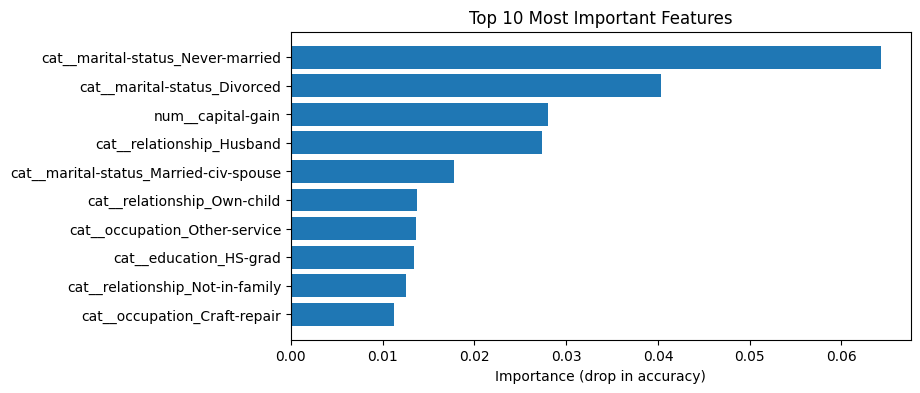

In [113]:
top = importance.head(10)
plt.figure(figsize=(8,4))
plt.barh(top['feature'], top['importance_mean'])
plt.xlabel("Importance (drop in accuracy)")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()
plt.show()

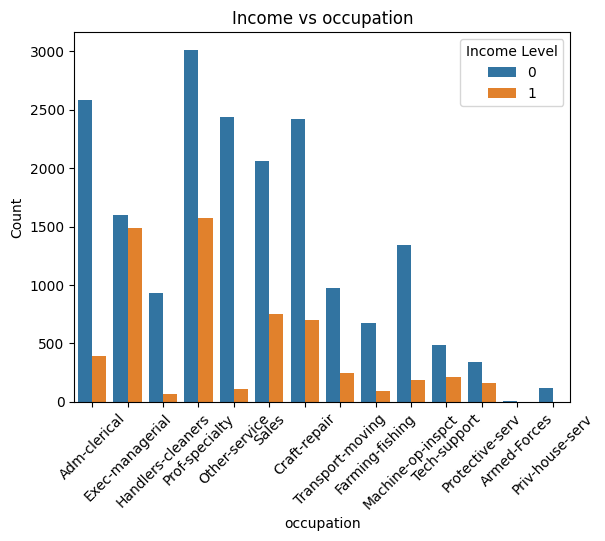

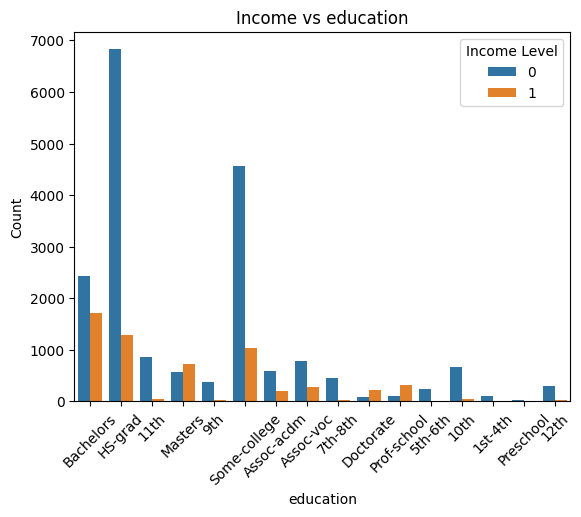

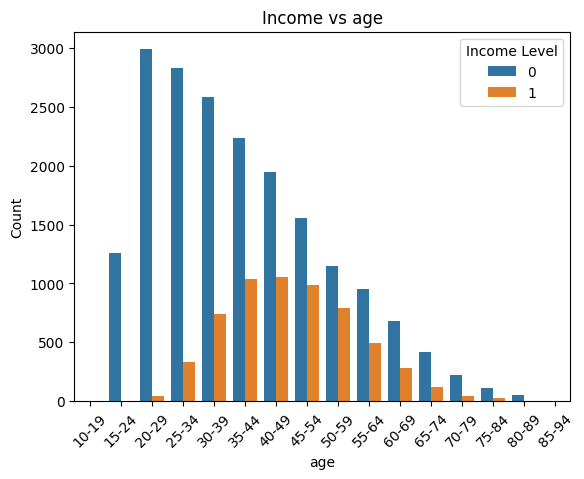

In [84]:

for col in Train.columns    :
    dominant_value = Train[col].mode()[0]
    Train[col] = Train[col].fillna(dominant_value)


cols = ["occupation","education"]
for col in cols:
    sns.countplot(data = Train, x = col, hue = "income")
    plt.title(f"Income vs {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="Income Level")
    plt.show()

bins   = list(range(10, 91, 5))     
labels = [f"{b}-{b+9}" for b in bins[:-1]]
Train['age_binned'] = pd.cut(Train['age'], labels= labels, right = False, bins = bins)
sns.countplot(data = Train, x = 'age_binned', hue = "income")
plt.title("Income vs age")
plt.xlabel('age')
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Income Level")
plt.show()

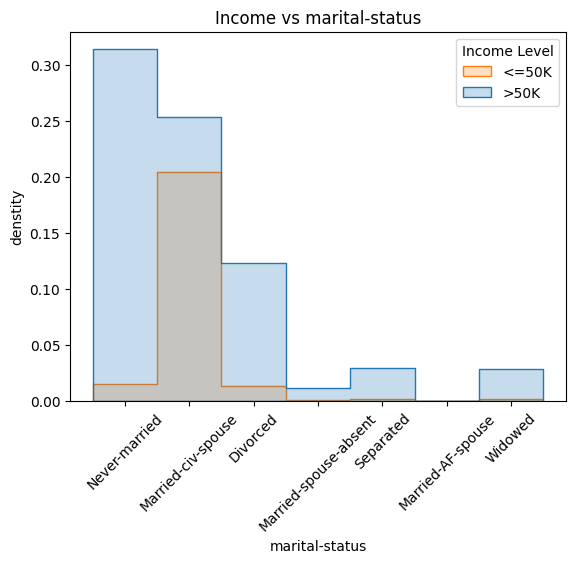

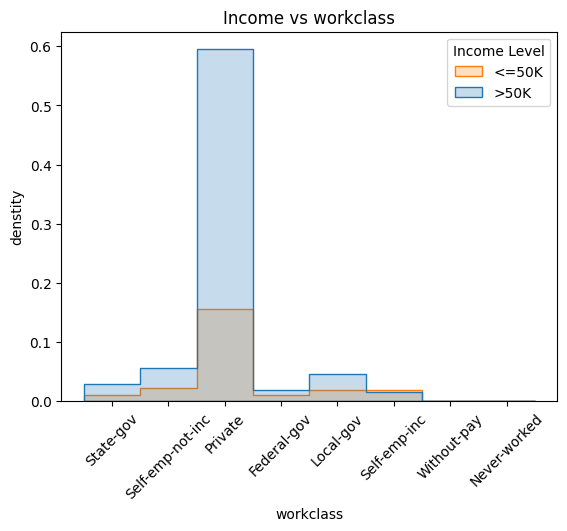

In [123]:
cols = ["marital-status","workclass"]
for col in cols:
    sns.histplot(data = Train, x = col, hue = "income", kde =False, stat = "density", element = "step")
    plt.title(f"Income vs {col}")
    plt.xlabel(col)
    plt.ylabel("denstity")
    plt.xticks(rotation=45)
    plt.legend(title="Income Level", labels = ['<=50K', '>50K'])
    plt.show()

